# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import class_weight, resample
import warnings
import joblib

warnings.filterwarnings('ignore')


# Parte 1: Lectura de Datos y Distribución de Clases


187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64

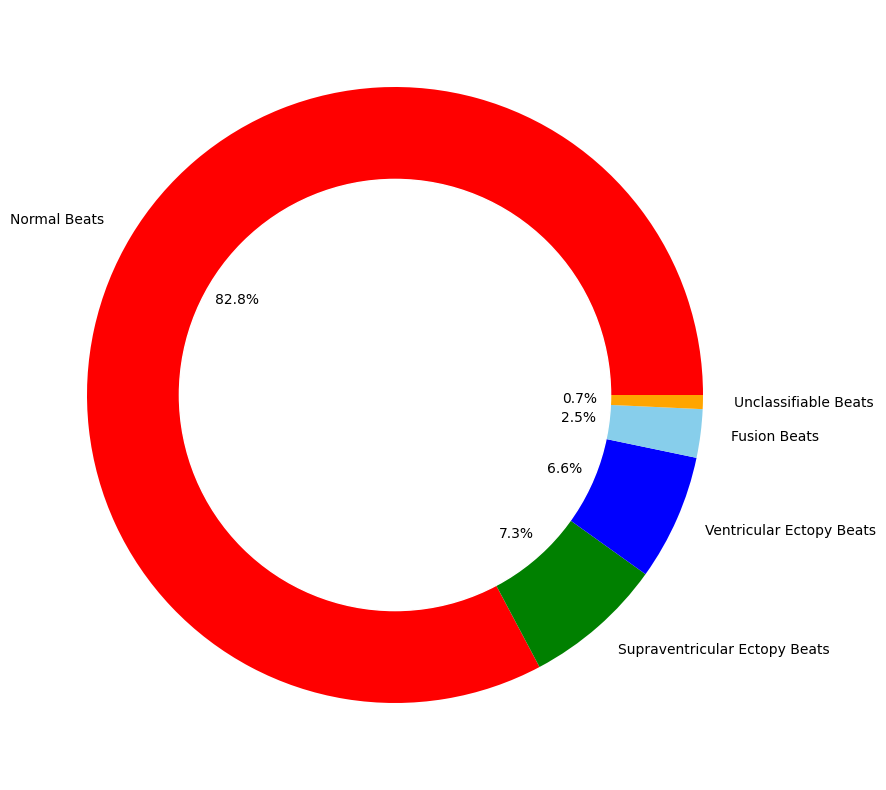

In [2]:
# Leer los datos
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)
abnormal_df = pd.read_csv('ptbdb_abnormal.csv', header=None)
normal_df = pd.read_csv('ptbdb_normal.csv', header=None)


train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
display(equilibre)

plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal Beats','Supraventricular Ectopy Beats','Ventricular Ectopy Beats','Fusion Beats','Unclassifiable Beats']
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Explicación:

- **Lectura de Datos:** Se cargan los archivos CSV que contienen datos de señales de ECG (Electrocardiograma). Cada archivo representa diferentes tipos de datos (entrenamiento, prueba, normal y anormal).

- **Conversión de Tipo:** La última columna de train_df (que contiene las etiquetas de clase) se convierte a entero.

- **Visualizar la distribución de Clases:** Se cuenta la cantidad de ejemplos en cada clase y se visualiza esta distribución mediante un gráfico circular, podemos ver que la distribucion no esta balanceada y la mayoria son normal beats.

# Parte 2: Remuestreo para Balancear las Clases


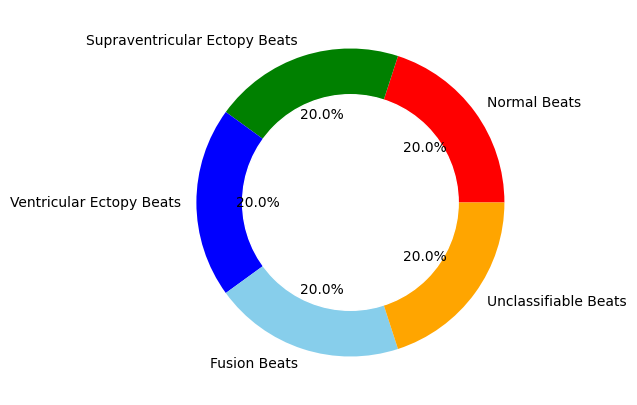

In [3]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

# Combinar los datasets remuestreados
balanced_train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

# Mostrar la nueva distribución de clases en el conjunto de entrenamiento
equilibre = balanced_train_df[187].value_counts()

plt.figure(figsize=(10, 5))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal Beats', 'Supraventricular Ectopy Beats', 'Ventricular Ectopy Beats', 'Fusion Beats', 'Unclassifiable Beats'],
        colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Explicación:

- **Separación de Clases:** Se separan los datos de entrenamiento en diferentes DataFrames según su clase.
  
- **Remuestreo:** Se realiza un remuestreo con reemplazo para aumentar el número de instancias de las clases minoritarias hasta 20000 ejemplos cada una.
  
- **Combinar Datos:** Se combinan los datos remuestreados para obtener un conjunto de entrenamiento balanceado.
  
- **Visualización:** Se visualiza la nueva distribución de clases, que ahora es balanceada.

Después del remuestreo, todas las clases tienen el mismo número de instancias, lo que debería mejorar el rendimiento del modelo en las clases minoritarias.

# Parte 3: Entrenamiento del Modelo y Evaluación


### Random Forest

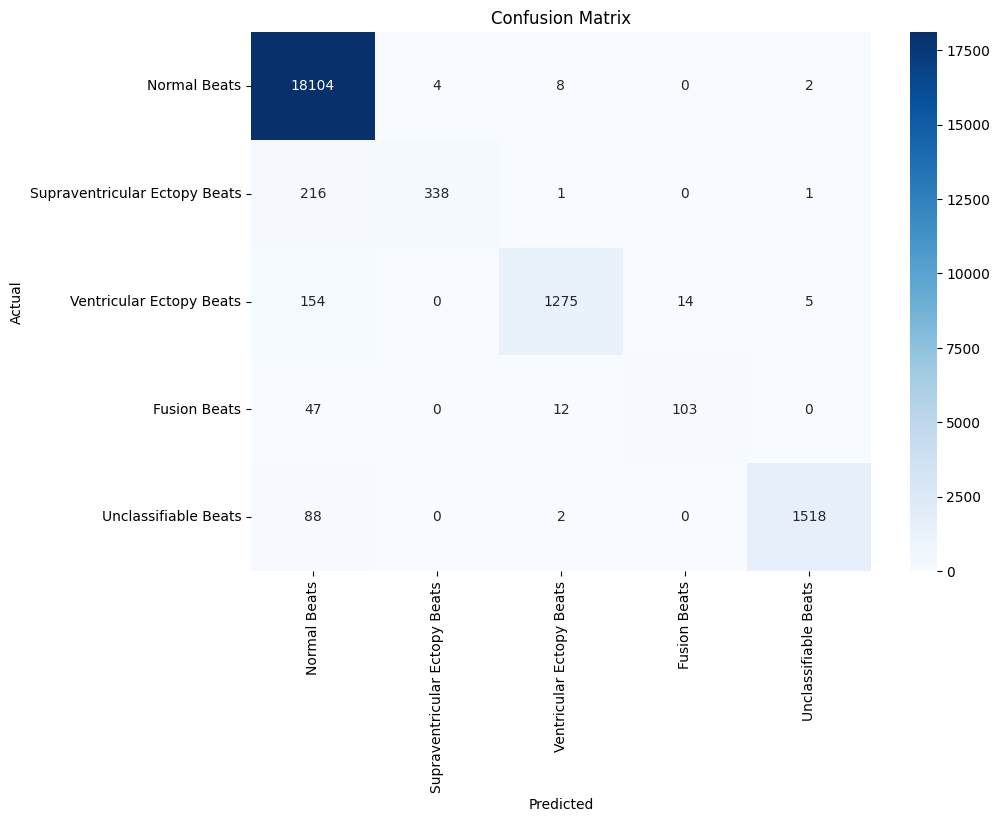

                               precision    recall  f1-score   support

                 Normal Beats       0.97      1.00      0.99     18118
Supraventricular Ectopy Beats       0.99      0.61      0.75       556
     Ventricular Ectopy Beats       0.98      0.88      0.93      1448
                 Fusion Beats       0.88      0.64      0.74       162
         Unclassifiable Beats       0.99      0.94      0.97      1608

                     accuracy                           0.97     21892
                    macro avg       0.96      0.81      0.87     21892
                 weighted avg       0.97      0.97      0.97     21892



['ecg_model.pkl']

In [4]:
# Split the data into features and labels
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

# Initialize and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Normal Beats', 'Supraventricular Ectopy Beats', 'Ventricular Ectopy Beats', 'Fusion Beats', 'Unclassifiable Beats']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

# Save the model to a file
joblib.dump(model, 'ecg_model.pkl')


### Árbol de Decisión

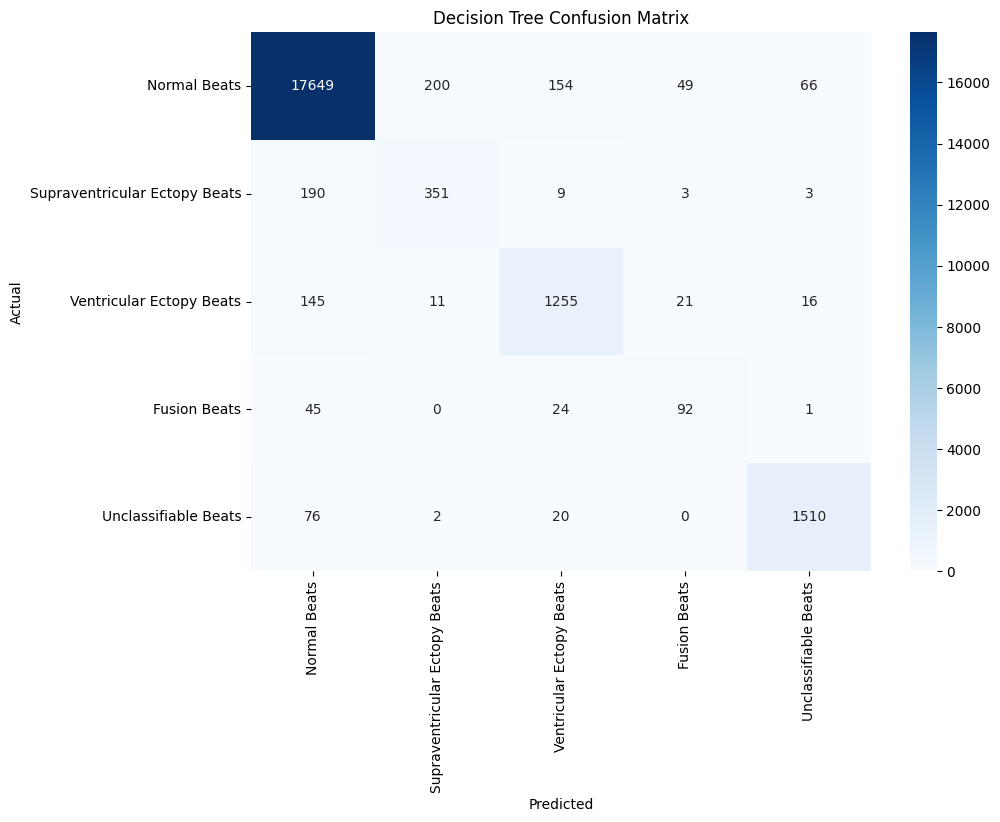

                               precision    recall  f1-score   support

                 Normal Beats       0.97      0.97      0.97     18118
Supraventricular Ectopy Beats       0.62      0.63      0.63       556
     Ventricular Ectopy Beats       0.86      0.87      0.86      1448
                 Fusion Beats       0.56      0.57      0.56       162
         Unclassifiable Beats       0.95      0.94      0.94      1608

                     accuracy                           0.95     21892
                    macro avg       0.79      0.80      0.79     21892
                 weighted avg       0.95      0.95      0.95     21892



['decision_tree_model.pkl']

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Inicializar y entrenar el clasificador de Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predecir los resultados del conjunto de prueba
dt_y_pred = dt_model.predict(X_test)

# Generar la matriz de confusión
dt_cm = confusion_matrix(y_test, dt_y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
dt_report = classification_report(y_test, dt_y_pred, target_names=labels)
print(dt_report)

# Guardar el modelo en un archivo
joblib.dump(dt_model, 'decision_tree_model.pkl')


### Support Vector Machine (SVM)

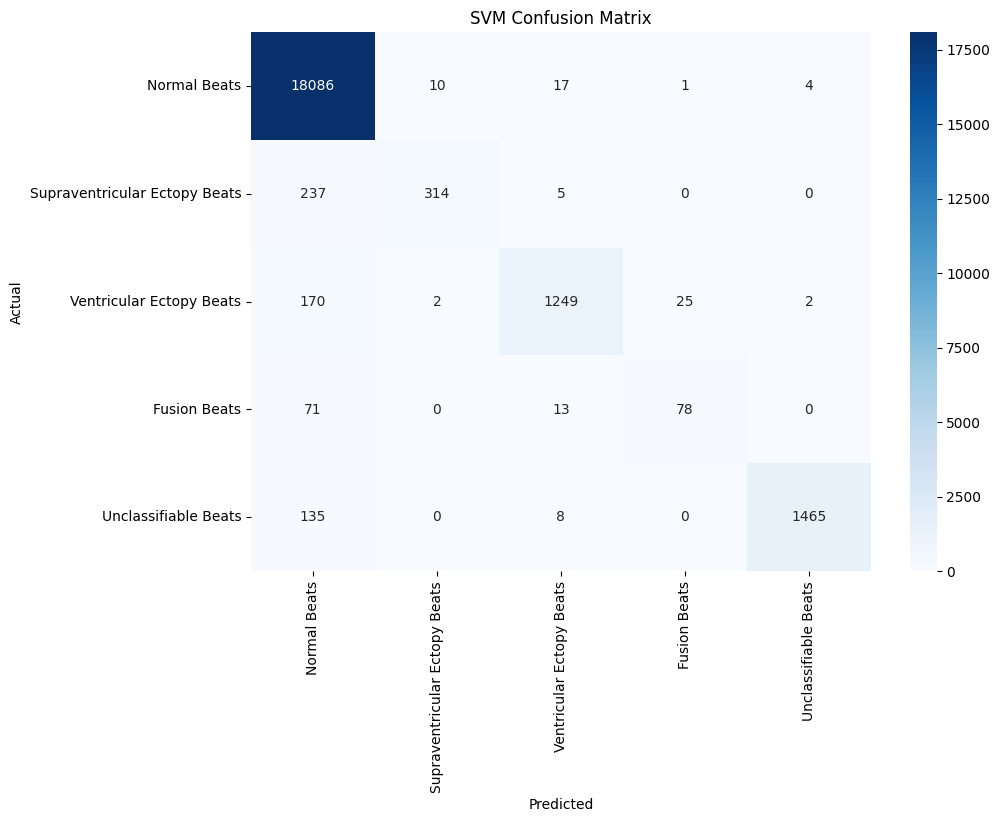

                               precision    recall  f1-score   support

                 Normal Beats       0.97      1.00      0.98     18118
Supraventricular Ectopy Beats       0.96      0.56      0.71       556
     Ventricular Ectopy Beats       0.97      0.86      0.91      1448
                 Fusion Beats       0.75      0.48      0.59       162
         Unclassifiable Beats       1.00      0.91      0.95      1608

                     accuracy                           0.97     21892
                    macro avg       0.93      0.76      0.83     21892
                 weighted avg       0.97      0.97      0.97     21892



['svm_model.pkl']

In [6]:
from sklearn.svm import SVC

# Inicializar y entrenar el clasificador SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predecir los resultados del conjunto de prueba
svm_y_pred = svm_model.predict(X_test)

# Generar la matriz de confusión
svm_cm = confusion_matrix(y_test, svm_y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
svm_report = classification_report(y_test, svm_y_pred, target_names=labels)
print(svm_report)

# Guardar el modelo en un archivo
joblib.dump(svm_model, 'svm_model.pkl')


### K-Nearest Neighbors (KNN)

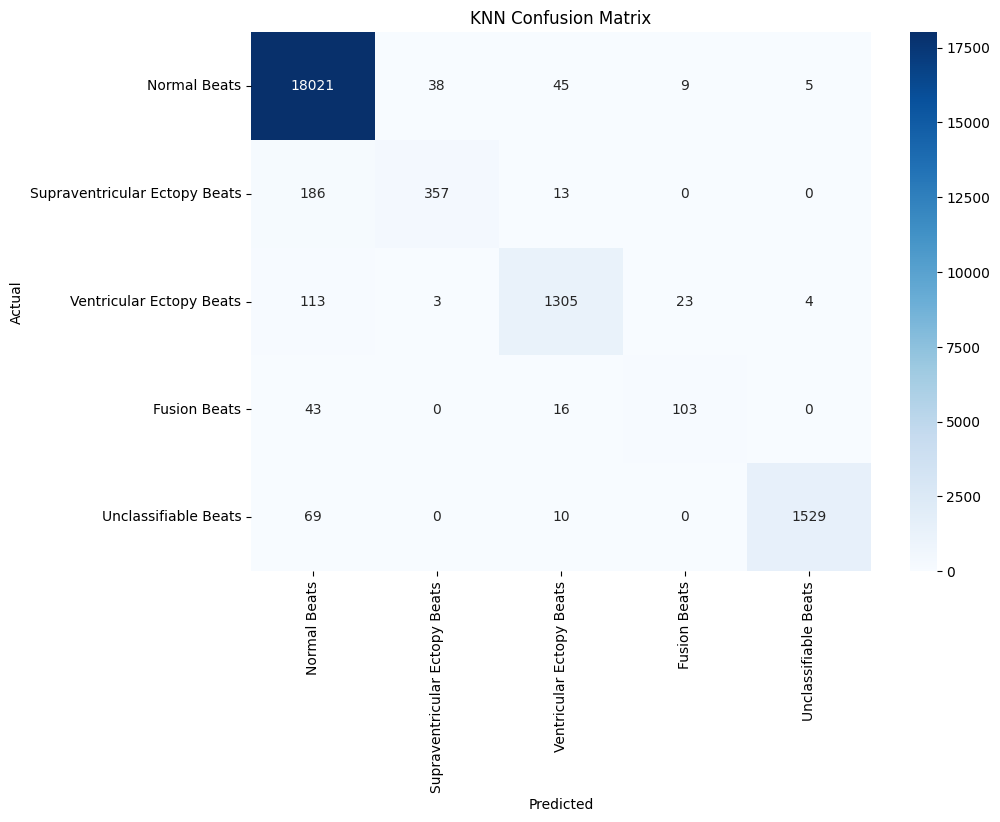

                               precision    recall  f1-score   support

                 Normal Beats       0.98      0.99      0.99     18118
Supraventricular Ectopy Beats       0.90      0.64      0.75       556
     Ventricular Ectopy Beats       0.94      0.90      0.92      1448
                 Fusion Beats       0.76      0.64      0.69       162
         Unclassifiable Beats       0.99      0.95      0.97      1608

                     accuracy                           0.97     21892
                    macro avg       0.91      0.82      0.86     21892
                 weighted avg       0.97      0.97      0.97     21892



['knn_model.pkl']

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializar y entrenar el clasificador KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predecir los resultados del conjunto de prueba
knn_y_pred = knn_model.predict(X_test)

# Generar la matriz de confusión
knn_cm = confusion_matrix(y_test, knn_y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
knn_report = classification_report(y_test, knn_y_pred, target_names=labels)
print(knn_report)

# Guardar el modelo en un archivo
joblib.dump(knn_model, 'knn_model.pkl')


### Gradient Boosting Machines (GBM)

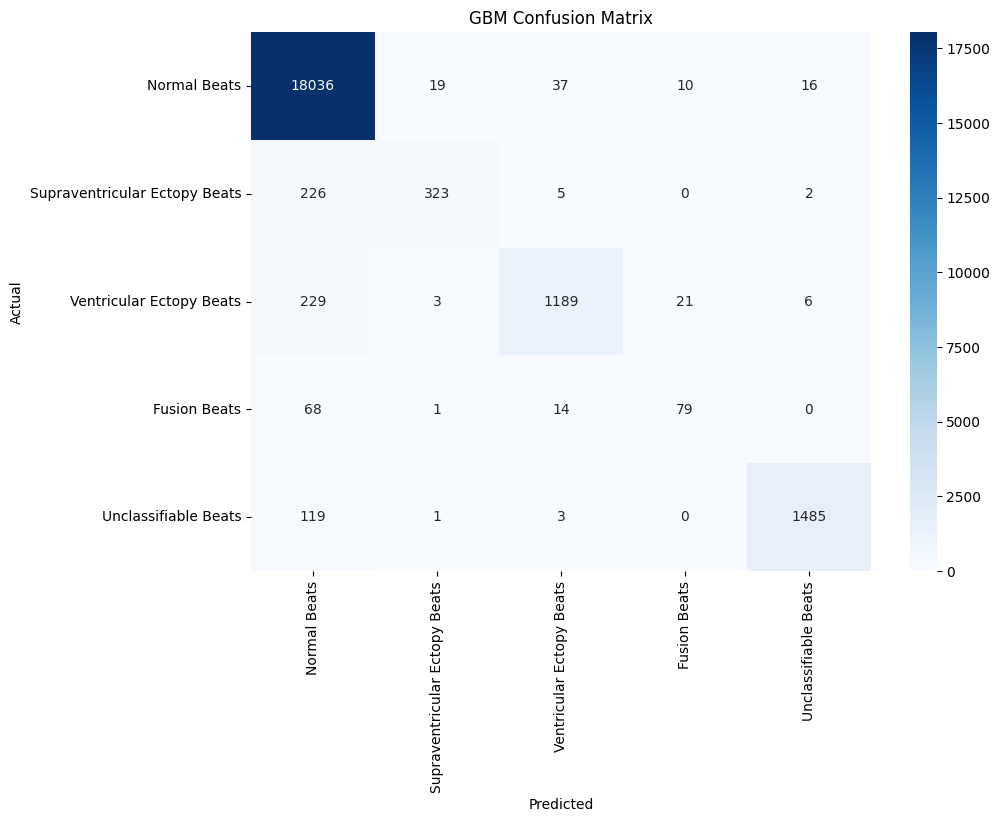

                               precision    recall  f1-score   support

                 Normal Beats       0.97      1.00      0.98     18118
Supraventricular Ectopy Beats       0.93      0.58      0.72       556
     Ventricular Ectopy Beats       0.95      0.82      0.88      1448
                 Fusion Beats       0.72      0.49      0.58       162
         Unclassifiable Beats       0.98      0.92      0.95      1608

                     accuracy                           0.96     21892
                    macro avg       0.91      0.76      0.82     21892
                 weighted avg       0.96      0.96      0.96     21892



['gbm_model.pkl']

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# Inicializar y entrenar el clasificador Gradient Boosting
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Predecir los resultados del conjunto de prueba
gbm_y_pred = gbm_model.predict(X_test)

# Generar la matriz de confusión
gbm_cm = confusion_matrix(y_test, gbm_y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(gbm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GBM Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
gbm_report = classification_report(y_test, gbm_y_pred, target_names=labels)
print(gbm_report)

# Guardar el modelo en un archivo
joblib.dump(gbm_model, 'gbm_model.pkl')


### Redes Neuronales Artificiales (ANN)

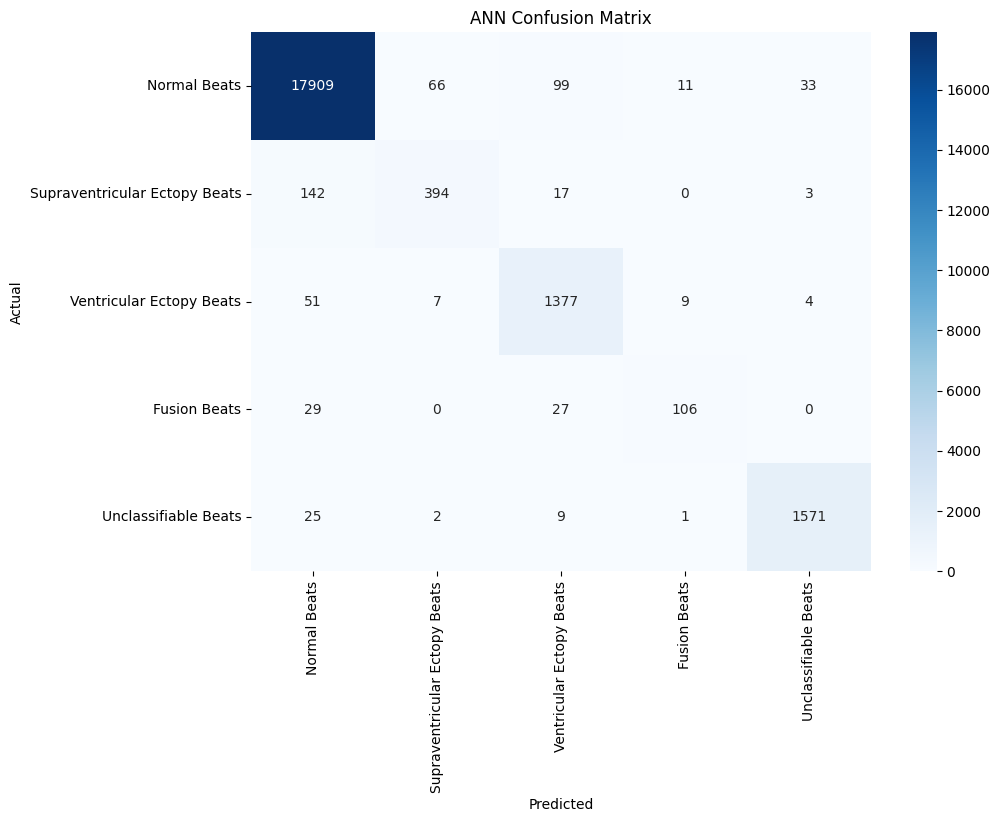

                               precision    recall  f1-score   support

                 Normal Beats       0.99      0.99      0.99     18118
Supraventricular Ectopy Beats       0.84      0.71      0.77       556
     Ventricular Ectopy Beats       0.90      0.95      0.93      1448
                 Fusion Beats       0.83      0.65      0.73       162
         Unclassifiable Beats       0.98      0.98      0.98      1608

                     accuracy                           0.98     21892
                    macro avg       0.91      0.86      0.88     21892
                 weighted avg       0.98      0.98      0.98     21892



['ann_model.pkl']

In [9]:
from sklearn.neural_network import MLPClassifier

# Inicializar y entrenar el clasificador de Redes Neuronales
ann_model = MLPClassifier(random_state=42, max_iter=300)
ann_model.fit(X_train, y_train)

# Predecir los resultados del conjunto de prueba
ann_y_pred = ann_model.predict(X_test)

# Generar la matriz de confusión
ann_cm = confusion_matrix(y_test, ann_y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN Confusion Matrix')
plt.show()

# Imprimir el reporte de clasificación
ann_report = classification_report(y_test, ann_y_pred, target_names=labels)
print(ann_report)

# Guardar el modelo en un archivo
joblib.dump(ann_model, 'ann_model.pkl')


### Global

               Model  Accuracy  F1 Score  Precision    Recall
0      Random Forest  0.974694  0.973072   0.974801  0.974694
1      Decision Tree  0.952722  0.952841   0.952967  0.952722
2                SVM  0.968025  0.965731   0.967583  0.968025
3                KNN  0.973643  0.972494   0.972746  0.973643
4  Gradient Boosting  0.964371  0.962120   0.963416  0.964371
5                ANN  0.975562  0.975041   0.975057  0.975562


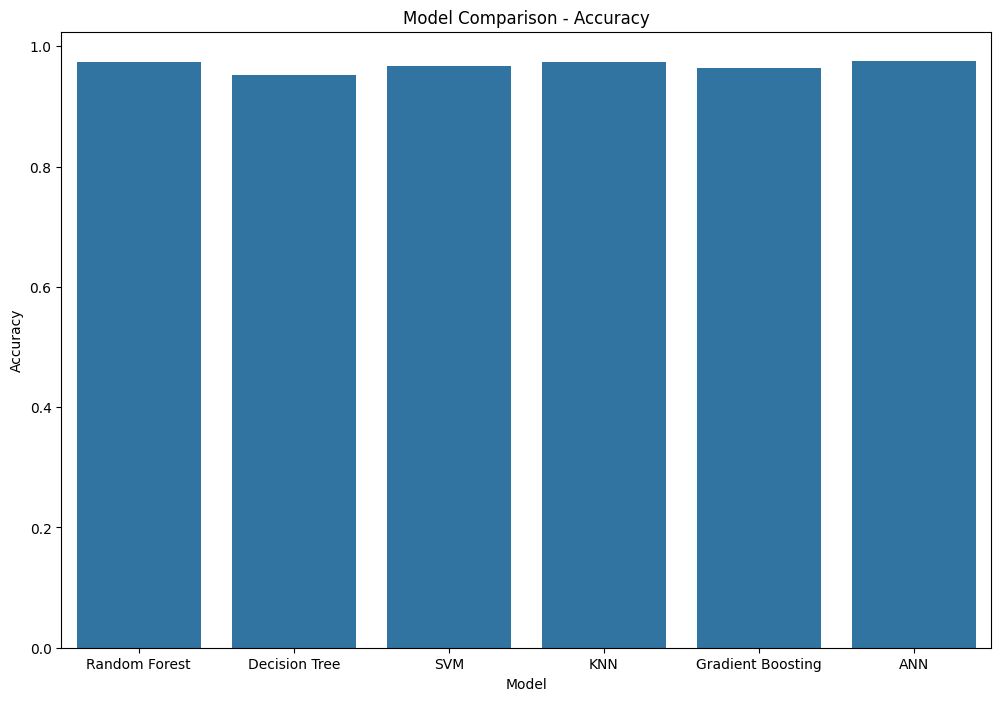

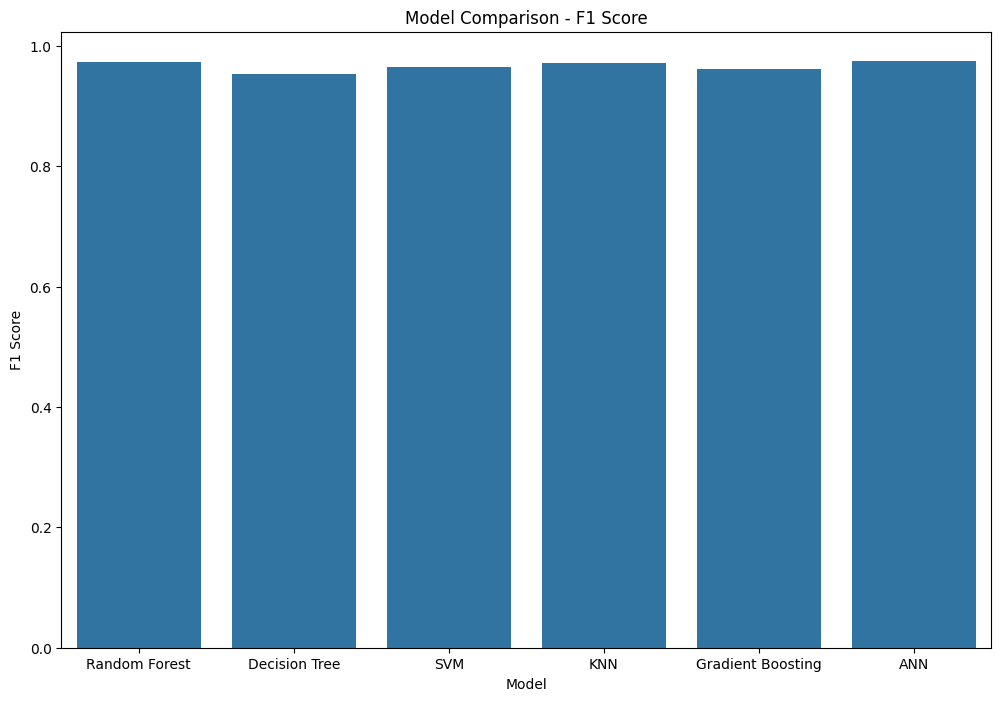

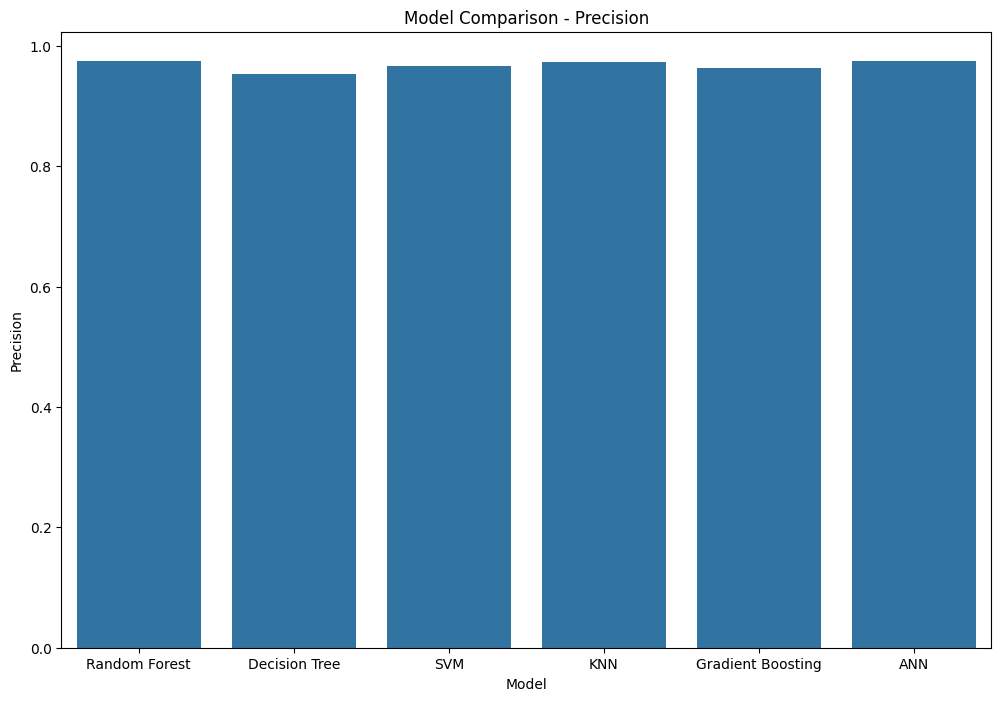

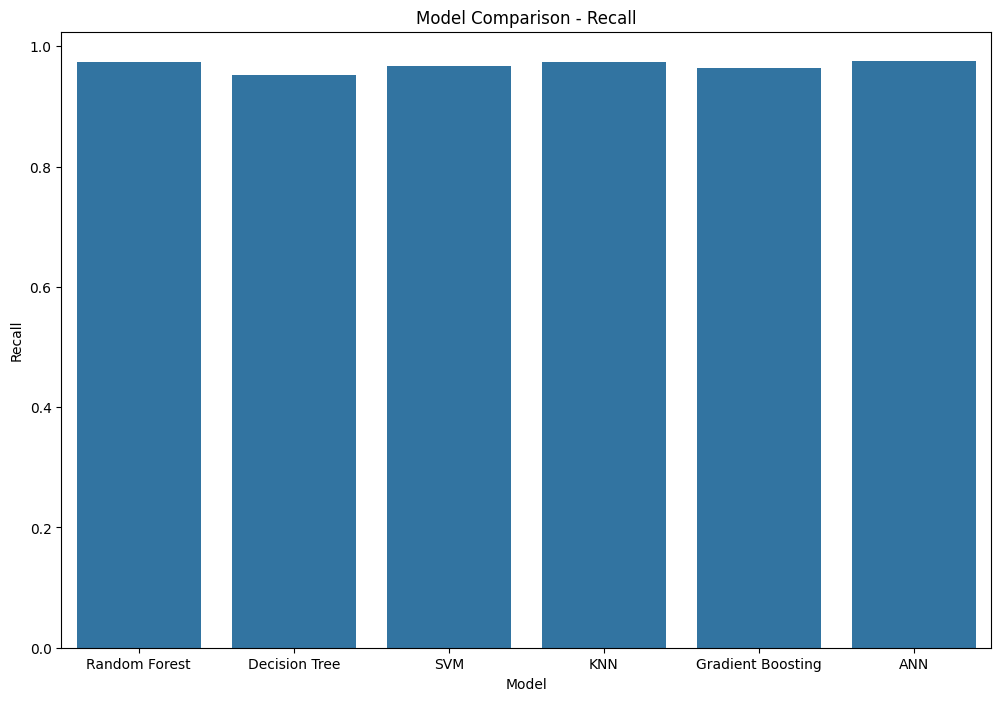

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Inicializar los modelos
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "ANN": MLPClassifier(random_state=42, max_iter=300)
}

# Entrenar los modelos y recopilar las métricas
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted')
    })

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Mostrar el DataFrame
print(results_df)

# Graficar las métricas
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Comparison - Accuracy")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="F1 Score", data=results_df)
plt.title("Model Comparison - F1 Score")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Precision", data=results_df)
plt.title("Model Comparison - Precision")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Recall", data=results_df)
plt.title("Model Comparison - Recall")
plt.show()


# Parte 4: Predicciones en Datos obtenidos por nuestro Electrocardiografo


First few rows of the new ECG data:
   0.000000   10.012894
0          1  10.992991
1          2  11.779607
2          3  12.412352
3          4  12.930900
4          5  13.374863


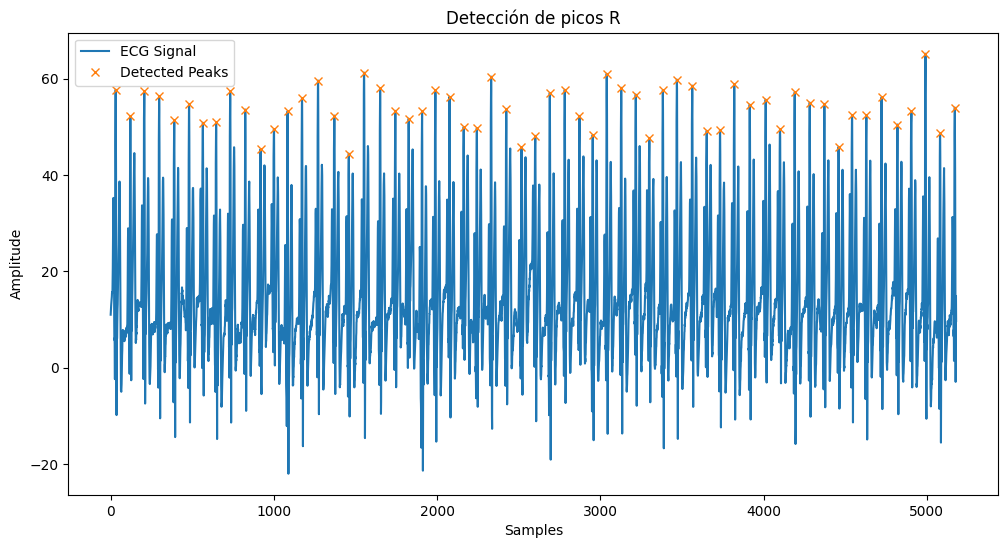

Predictions for the new ECG data:
[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Number of segments: 59, Number of predictions: 59


interactive(children=(IntSlider(value=0, description='segment_index', max=58), Output()), _dom_classes=('widge…

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import joblib
import ipywidgets as widgets
from ipywidgets import interact

# 1. Cargar los datos del archivo Excel
new_ecg_data = pd.read_excel('test5_bueno.xls')

# Mostrar las primeras filas de los datos para entender la estructura
print("First few rows of the new ECG data:")
print(new_ecg_data.head())

# 2. Preprocesar los datos
# Suponiendo que los valores de ECG están en la segunda columna
ecg_values = new_ecg_data.iloc[:, 1].values  # Extraer los valores de ECG

# Eliminar los últimos 500 datos
ecg_values = ecg_values[:-500]

# 3. Detectar picos R
height_threshold = 0.5  # Ajustar este parámetro según sea necesario
distance_threshold = 50  # Ajustar la distancia mínima en muestras (ms)
peaks, _ = find_peaks(ecg_values, height=height_threshold, distance=distance_threshold)

# Mostrar los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(ecg_values, label='ECG Signal')
plt.plot(peaks, ecg_values[peaks], "x", label='Detected Peaks')
plt.title('Detección de picos R')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# 4. Segmentar en latidos cardíacos centrados en picos R
samples_before = 35  # Número de muestras antes del pico R
samples_after = 35   # Número de muestras después del pico R
window_size = samples_before + samples_after + 1  # Longitud total del segmento

segments = []
for peak in peaks:
    start = max(0, peak - samples_before)
    end = min(len(ecg_values), peak + samples_after + 1)
    segment = ecg_values[start:end]
    if len(segment) < window_size:  # Rellenar con ceros si es necesario
        segment = np.pad(segment, (0, window_size - len(segment)), 'constant')
    segments.append(segment)

# Rellenar cada segmento con ceros hasta alcanzar 187 muestras
final_segments = [np.pad(segment, (0, 187 - len(segment)), 'constant') for segment in segments]

# Convertir las secuencias uniformes en un DataFrame
X_new = pd.DataFrame(final_segments)

# Cargar el modelo entrenado
model = joblib.load('ecg_model.pkl')

# Hacer predicciones con el modelo
predictions = model.predict(X_new)

# Mostrar las predicciones
print("Predictions for the new ECG data:")
print(predictions)

# Verificar el número de segmentos y predicciones
num_segments = len(final_segments)
num_predictions = len(predictions)
print(f"Number of segments: {num_segments}, Number of predictions: {num_predictions}")

# Asegurarse de que los índices estén dentro de los límites
max_index = min(num_segments, num_predictions) - 1

# Función para graficar cada segmento
def plot_segment(segment_index):
    plt.figure(figsize=(12, 6))
    plt.plot(final_segments[segment_index])
    plt.title(f'Segment {segment_index} - Prediction: {predictions[segment_index]}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

# Crear el slider interactivo con el rango correcto
interact(plot_segment, segment_index=widgets.IntSlider(min=0, max=max_index, step=1, value=0));

Explicación:

- Carga de Nuevos Datos: Se cargan nuevos datos de ECG desde un archivo Excel.
- Preprocesamiento: Se extraen los valores de ECG y se eliminan los últimos 500 datos.
- Detección de Picos R: Se detectan los picos R en la señal de ECG.
- Segmentación: Se segmenta la señal en latidos cardíacos centrados en los picos R.
- Predicciones: Se cargan el modelo entrenado y se hacen predicciones sobre los nuevos segmentos de ECG.
- Visualización: Se visualizan los segmentos y sus predicciones mediante un control deslizante interactivo.

Análisis de Resultados:

Las predicciones indican el tipo de latido cardíaco detectado en cada segmento de ECG. La visualización interactiva permite revisar manualmente cada segmento y su predicción.

# Parte 5: Evaluación en Nuevos Datos Etiquetados (Normal Beats)


Number of samples: 4046
Number of features: 188
Predictions:
[0 0 0 ... 0 0 0]


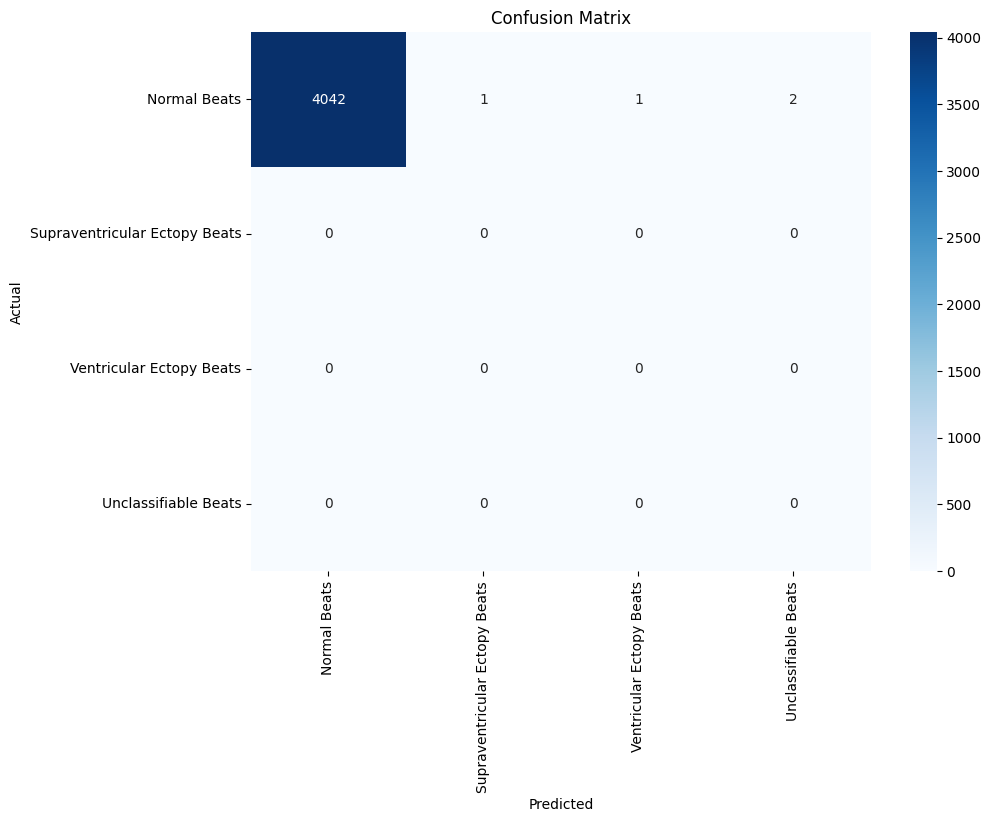

Classification Report:
                               precision    recall  f1-score   support

                 Normal Beats       1.00      1.00      1.00      4046
Supraventricular Ectopy Beats       0.00      0.00      0.00         0
     Ventricular Ectopy Beats       0.00      0.00      0.00         0
         Unclassifiable Beats       0.00      0.00      0.00         0

                     accuracy                           1.00      4046
                    macro avg       0.25      0.25      0.25      4046
                 weighted avg       1.00      1.00      1.00      4046



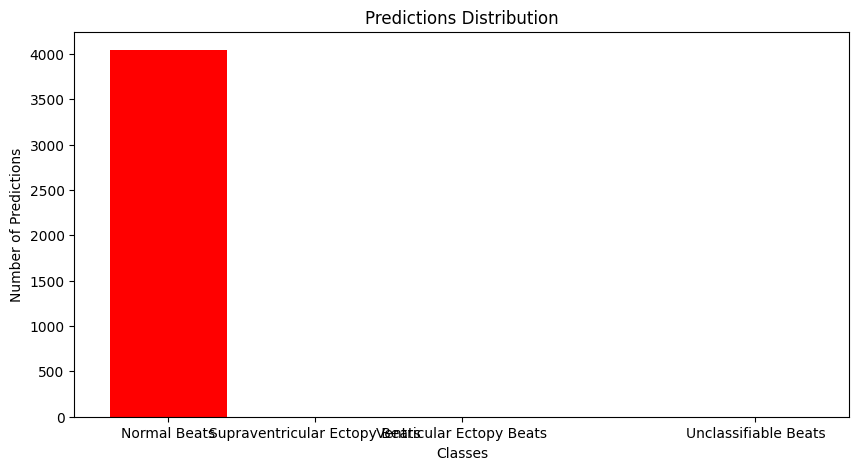

In [15]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Cargar el modelo desde el archivo
model = joblib.load('ecg_model.pkl')

# Cargar los nuevos datos
new_data = pd.read_csv('ptbdb_normal.csv', header=None)

# Cargar el archivo CSV
file_path = 'ptbdb_normal.csv'  # Reemplaza con la ruta real del archivo
data = pd.read_csv(file_path, header=None)

# Obtener el número de muestras (filas) y características (columnas)
num_samples, num_features = data.shape

print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")
, header=None)  # Reemplaza con la ruta real del archivo

# Excluir la columna de etiqueta si existe
if new_data.shape[1] == 188:
    true_labels = new_data.iloc[:, -1]
    new_data = new_data.iloc[:, :-1]
else:
    true_labels = None

# Asegurarse de que new_data tenga 187 características
assert new_data.shape[1] == 187, f"Expected 187 features, got {new_data.shape[1]}"

# Realizar predicciones usando el modelo entrenado
predictions = model.predict(new_data)

# Salida de las predicciones
print("Predictions:")
print(predictions)

# Definir las etiquetas conocidas
known_labels = ['Normal Beats', 'Supraventricular Ectopy Beats', 'Ventricular Ectopy Beats', 'Fusion Beats', 'Unclassifiable Beats']

# Si hay etiquetas verdaderas, generar la matriz de confusión y el informe de clasificación
if true_labels is not None:
    # Asegurarse de que las etiquetas verdaderas y las predicciones tengan las mismas clases
    unique_labels = np.union1d(np.unique(true_labels), np.unique(predictions)).astype(int)
    labels = [known_labels[i] for i in unique_labels]

    # Generar la matriz de confusión
    cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Imprimir el informe de clasificación
    report = classification_report(true_labels, predictions, labels=unique_labels, target_names=labels)
    print("Classification Report:")
    print(report)

# Gráfico de predicciones
unique, counts = np.unique(predictions, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique.astype(int), counts, color=['red', 'green', 'blue', 'skyblue', 'orange'])
plt.xticks(ticks=unique.astype(int), labels=[known_labels[i] for i in unique])
plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.title('Predictions Distribution')
plt.show()

**Explicación:**

Carga del Modelo y Nuevos Datos: Se carga el modelo entrenado y los nuevos datos etiquetados.

Preprocesamiento: Se excluye la columna de etiquetas si está presente y se verifica que los datos tengan el número correcto de características.

Predicciones: Se realizan predicciones sobre los nuevos datos.

Evaluación: Si las etiquetas verdaderas están disponibles, se genera y visualiza una matriz de confusión y un informe de clasificación.

**Análisis de Resultados:**

Las predicciones se comparan con las etiquetas verdaderas para evaluar el rendimiento del modelo en los nuevos datos. En este caso, el modelo tiene una precisión perfecta para "Normal Beats", y no ha detectado ninguna de las otras clases lo cual es bueno ya que es un fichreo con solo muestras normales

**Conclusiones**

El proceso seguido es exhaustivo y detallado, incluyendo desde la carga y preprocesamiento de datos hasta el entrenamiento, evaluación y uso del modelo en nuevos datos. Los principales hallazgos y áreas de mejora son:

Balanceo de Clases: Es crucial para manejar conjuntos de datos desbalanceados. El remuestreo mejoró la representación de clases minoritarias.

Evaluación del Modelo: La matriz de confusión y el informe de clasificación son herramientas valiosas para entender el rendimiento del modelo.
